# Adaptive Learning Path Workflow with LangGraph

This notebook rebuilds the adaptive learning path workflow using only LangGraph nodes and edges. Each workflow step is a node, and transitions are managed by the LangGraph graph API.

In [28]:
# 1. Import Required Libraries
from langgraph.graph import StateGraph
import re
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import os
import json
from openai import OpenAI
from dotenv import load_dotenv

# Load environment variables from a .env file if present
load_dotenv()

# Gemini/OpenRouter config (set via environment variables)
GEMINI_MODEL = os.environ.get('GEMINI_MODEL')
GEMINI_API_KEY = os.environ.get('GEMINI_API_KEY', None)

print(f"Using Gemini Model: {GEMINI_MODEL}")
print(f"GEMINI_API_KEY set: {'yes' if GEMINI_API_KEY else 'no'}")


Using Gemini Model: openrouter/sherlock-dash-alpha
GEMINI_API_KEY set: yes


In [29]:
# 2. Define Roadmap State Structure
class RoadmapState:
    def __init__(self):
        self.topic = None
        self.goal = None
        self.learning_style = None
        self.available_time = None
        self.roadmap = None
        self.feedback = None
        self.revised_roadmap = None
        self.estimated_level = None
        self.prereqs_needed = None
        self.primer = None
        self.schedule = None
        self.target_duration_weeks = None
        self.resources = None
        self.module_progress = {}
        self.quiz_scores = []
        self.timestamps = {}
    def to_dict(self):
        return self.__dict__


In [30]:
# 3. Define Node Functions
# Each function below is a workflow node
def node_topic_goal(state):
    print("Welcome to the Roadmap/Learning Path Maker!")
    state['topic'] = input("Enter the topic you want to learn (e.g., Python for Data Science): ")
    state['goal'] = input("Describe your learning goal (e.g., Get a job, Build a project, Pass a course): ")
    import datetime
    state.setdefault('timestamps', {})
    state['timestamps']['started'] = datetime.datetime.utcnow().isoformat() + 'Z'
    return state
def call_gemini(prompt, model=None, api_key=None, max_tokens=512, timeout_seconds=60):
    """Call OpenRouter via the openai-python client (OpenAI class).
    - Fails fast if no API key is configured (raises ValueError).
    - Logs timing and errors to help debug why requests don't appear in OpenRouter logs.
    """
    import time
    if model is None:
        model = GEMINI_MODEL
    # resolve API key from parameter or environment
    if api_key is None:
        api_key = os.environ.get('GEMINI_API_KEY')
    if not api_key:
        # Fail fast — do not prompt interactively in notebook runs
        raise ValueError('GEMINI_API_KEY not set. Set env var GEMINI_API_KEY before running or pass api_key to call_gemini.')
    # Minimal debug info (do NOT print the key itself)
    print(f"[LLM] calling model={model} (api_key set: yes) — prompt preview: {prompt[:120].replace('\n',' ')}...")
    client = OpenAI(base_url="https://openrouter.ai/api/v1", api_key=api_key)
    t0 = time.time()
    try:
        # include only required args to reduce client-side shaping issues
        completion = client.chat.completions.create(
            model=model,
            messages=[{"role": "user", "content": [{"type": "text", "text": prompt}]}],
            max_tokens=max_tokens,
        )
        duration = time.time() - t0
        print(f"[LLM] request completed in {duration:.2f}s")
    except Exception as e:
        duration = time.time() - t0
        print(f"[LLM] request failed after {duration:.2f}s: {e}")
        # Surface the error so you see it in notebook output and can inspect OpenRouter logs
        raise
    # Normalize returned content
    content = None
    try:
        content = completion.choices[0].message.content
    except Exception:
        try:
            content = completion.choices[0].text
        except Exception:
            content = str(completion)
    if isinstance(content, list):
        parts = []
        for part in content:
            if isinstance(part, dict) and 'text' in part:
                parts.append(part['text'])
            elif isinstance(part, str):
                parts.append(part)
        return ''.join(parts)
    return str(content)
def fetch_level_descriptions_batch(topic, model=None, api_key=None):
    """Request a single JSON object from the LLM that maps CEFR levels to short descriptions.
    Returns a dict: { 'None': '...', 'A1': '...', ... }
    """
    import json, re
    if model is None:
        model = GEMINI_MODEL
    prompt = (
        f"Return a JSON object mapping the following levels to a short phrase or one-sentence description for the topic '{topic}':\\n"
        "Levels: None, A1, A2, B1, B2, C1, C2.\\n"
        "Format EXACTLY as a JSON object with those keys and short values. Do not add commentary. Example response: {\"None\": \"No prior knowledge\", \"A1\": \"Familiar with basics\", ... }\\n"
        "Keep each value concise (one short sentence or phrase)."
    )
    resp = call_gemini(prompt, model=model, api_key=api_key, max_tokens=400)
    print("[LLM] raw level-descriptions response preview:", resp[:400])
    # Try to parse JSON directly
    try:
        parsed = json.loads(resp)
        if isinstance(parsed, dict):
            return {k: str(v).strip() for k, v in parsed.items()}
    except Exception:
        # attempt to extract JSON substring
        m = re.search(r"(\{[\s\S]*\})", resp)
        if m:
            try:
                parsed = json.loads(m.group(1))
                if isinstance(parsed, dict):
                    return {k: str(v).strip() for k, v in parsed.items()}
            except Exception:
                pass
    # If parsing failed, fallback to a safe default (call per-level)
    print('[LLM] failed to parse JSON from batch response; falling back to individual calls')
    levels = ['None', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2']
    descriptions = {}
    for lvl in levels:
        prompt = f"For the topic '{topic}', in one short sentence or a few phrases describe what the '{lvl}' skill level means. Be practical and concise."
        desc = call_gemini(prompt, model=model, api_key=api_key, max_tokens=160)
        descriptions[lvl] = desc.strip() if desc else f"({lvl} description unavailable)"
    return descriptions
def get_topic_level_descriptions_cached(state):
    """Return cached level descriptions in state['_level_desc_cache'] if present, otherwise fetch and cache them."""
    if '_level_desc_cache' in state and state['_level_desc_cache'].get('topic') == state.get('topic') :
        return state['_level_desc_cache']['descriptions']
    descriptions = fetch_level_descriptions_batch(state.get('topic', 'the topic'))
    state['_level_desc_cache'] = {'topic': state.get('topic'), 'descriptions': descriptions}
    return descriptions
def node_level_selection(state):
    levels = ['None', 'A1', 'A2', 'B1', 'B2', 'C1', 'C2']
    # Use cached/batched descriptions to avoid repeated requests
    level_descriptions = get_topic_level_descriptions_cached(state)
    print(f"Select your current level for this topic: {state.get('topic', '')}")
    for i, lvl in enumerate(levels):
        print(f"  {i}: {lvl} - {level_descriptions.get(lvl, '')}")
    idx = input("Enter the number for your level (0-6): ").strip()
    try:
        idx = int(idx)
        if 0 <= idx < len(levels):
            state['estimated_level'] = levels[idx]
        else:
            state['estimated_level'] = 'None'
    except Exception:
        state['estimated_level'] = 'None'
    print(f"Selected level: {state['estimated_level']} - {level_descriptions.get(state['estimated_level'], '')}")
    return state
def node_background(state):
    state['learning_style'] = input("Preferred learning style (Videos, Reading, Projects, Interactive, Mixed): ").strip()
    state['available_time'] = input("How much time per week? (e.g., 5 hours): ").strip() or '5 hours'
    # Ask for commitment in weeks (new)
    weeks = input("How many weeks are you willing to commit to this plan? (e.g., 8): ").strip()
    try:
        state['target_duration_weeks'] = int(weeks)
    except Exception:
        state['target_duration_weeks'] = None
    return state
def node_prerequisite_check(state):
    prompt = f"You are an expert instructor for the topic: {state.get('topic')}. List up to 6 concise prerequisite topics or skills a learner should know before starting {state.get('topic')}."
    prereq_text = call_gemini(prompt)
    print('\n--- PREREQUISITES (LLM) ---\n')
    print(prereq_text)
    state['prereqs_needed'] = prereq_text.split('\n') if prereq_text else []
    wants_primer = input("Would you like a short primer that covers these prerequisites? (yes/no): ").strip().lower()
    if wants_primer in ('yes','y') and state.get('prereqs_needed') :
        primer_prompt = f"Create a short primer for: {', '.join([p for p in state['prereqs_needed'] if p])}"
        state['primer'] = call_gemini(primer_prompt)
        print(state['primer'])
    return state
def node_generate_roadmap(state):
    roadmap_prompt = f"Create a concise, actionable learning roadmap for the topic: {state.get('topic')}. Goal: {state.get('goal')}. Level: {state.get('estimated_level')}. Learning style: {state.get('learning_style')}. Time per week: {state.get('available_time')}."
    state['roadmap'] = call_gemini(roadmap_prompt)
    print("\n--- ROADMAP ---\n")
    print(state['roadmap'])
    return state
def node_review_feedback(state):
    print("\n--- USER REVIEW & FEEDBACK ---\n")
    print("Here is your generated roadmap:")
    print(state.get('roadmap', ''))
    feedback = input("Do you want to request changes to the roadmap? If yes, describe them. If no, type 'no': ").strip()
    state['feedback'] = feedback
    return state
def node_adaptive_branch(state):
    # Regenerate inline if feedback provided
    if state.get('feedback') and state['feedback'].strip().lower() != 'no':
        print("Adapting roadmap based on feedback...")
        state = node_generate_roadmap(state)
    return state
def node_resource_fetch(state):
    print("Fetching resources for modules...")
    state['resources'] = call_gemini(f"Suggest resources for roadmap: {state.get('roadmap', '')}")
    return state
def node_schedule_builder(state):
    print("Building schedule...")
    state['schedule'] = call_gemini(f"Build a schedule for roadmap: {state.get('roadmap', '')}")
    return state
def node_final_output(state):
    print("\n--- FINAL OUTPUT ---\n")
    print(f"Roadmap: {state.get('roadmap', '')}\nSchedule: {state.get('schedule', '')}\nResources: {state.get('resources', '')}")
    return state
def node_module_quiz_branch(state):
    print("Module quiz branch...")
    if 'quiz_scores' not in state:
        state['quiz_scores'] = []
    import datetime
    state['quiz_scores'].append({'module': 'Example', 'score': 3, 'timestamp': datetime.datetime.utcnow().isoformat() + 'Z'})
    return state
def node_progress_tracking(state):
    print("\n--- PROGRESS TRACKING ---\n")
    print(f"Module progress: {state.get('module_progress', {})}")
    print(f"Quiz scores: {state.get('quiz_scores', [])}")
    # Ask user whether to export schedule to .ics
    try:
        choice = input("Would you like to export the schedule to an .ics file? (yes/no): ").strip().lower()
        state['export_schedule'] = True if choice in ('yes', 'y') else False
    except Exception:
        # If input isn't available (non-interactive), default to False
        state['export_schedule'] = False
    return state
def node_export_schedule_ics(state):
    """Export the user's schedule to an .ics file. Behavior:
    - If `state['schedule_items']` exists as a list of {title,start,end}, use it.
    - Else, try to ask the LLM to convert `state['schedule']` (text) into JSON events.
    - If `state['target_duration_weeks']` is provided, expand events weekly across that duration.
    - Writes file `schedule-<timestamp>.ics` into the notebook working directory and adds `state['ics_file']` path.
    The node respects `state['export_schedule']` (bool). If False, it skips exporting.
    """
    # Respect user's choice (default: skip export)
    if not state.get('export_schedule', False):
        print('Export skipped (user chose not to export).')
        return state
    import datetime, uuid, os, json, re
    def to_dt_iso(s):
        # normalize strings like 2025-11-19T19:10:12Z or without Z
        try:
            if isinstance(s, str) and s.endswith('Z'):
                return datetime.datetime.fromisoformat(s.replace('Z','+00:00'))
            return datetime.datetime.fromisoformat(s)
        except Exception:
            # try parsing date only
            try:
                return datetime.datetime.strptime(s, '%Y-%m-%d')
            except Exception:
                return None
    events = []
    if 'schedule_items' in state and isinstance(state['schedule_items'], list) and state['schedule_items'] :
        events = state['schedule_items']
    else:
        # Try to extract structured events from free text schedule using the LLM
        sch_text = state.get('schedule','')
        if sch_text:
            prompt = f"""Convert the following schedule text into a JSON array of events. Each event should have 'title', 'start' (ISO8601), and 'end' (ISO8601).
Schedule text:
{sch_text}

Return ONLY valid JSON, example: [{{"title":"Module 1","start":"2025-11-20T10:00:00Z","end":"2025-11-20T12:00:00Z"}}]"""
            resp = None
            try:
                resp = call_gemini(prompt, max_tokens=600)
            except Exception as e:
                print('LLM parse for schedule failed:', e)
            if resp:
                # try json parse
                try:
                    parsed = json.loads(resp)
                    if isinstance(parsed, list):
                        events = parsed
                except Exception:
                    m = re.search(r"(\[\s*\{[\s\S]*\}\s*\])", resp)
                    if m:
                        try:
                            parsed = json.loads(m.group(1))
                            if isinstance(parsed, list):
                                events = parsed
                        except Exception:
                            pass
    # If user provided weeks, expand events weekly across that duration
    target_weeks = state.get('target_duration_weeks') or 0
    expanded_events = []
    if events and target_weeks and isinstance(target_weeks, int) and target_weeks > 0:
        for ev in events:
            s_raw = ev.get('start')
            e_raw = ev.get('end')
            sd = to_dt_iso(s_raw) if s_raw else None
            ed = to_dt_iso(e_raw) if e_raw else None
            if not sd or not ed:
                continue
            # create weekly occurrences
            for w in range(max(1, target_weeks)):
                occ_s = sd + datetime.timedelta(weeks=w)
                occ_e = ed + datetime.timedelta(weeks=w)
                expanded_events.append({
                    'title': ev.get('title','Study'),
                    'start': occ_s.isoformat().replace('+00:00','Z'),
                    'end': occ_e.isoformat().replace('+00:00','Z'),
                    'description': state.get('roadmap','')[:1000]
                })
        events = expanded_events
    # If still no events, create a series of placeholder weekly events if weeks provided
    if not events:
        print('No structured events found; writing placeholder calendar entries for the roadmap.')
        now = datetime.datetime.utcnow()
        base_start = now.replace(hour=9, minute=0, second=0, microsecond=0)
        weeks = target_weeks if isinstance(target_weeks, int) and target_weeks > 0 else 1
        events = []
        for w in range(weeks):
            start = base_start + datetime.timedelta(weeks=w)
            end = start + datetime.timedelta(hours=1)
            events.append({'title': f"Study: {state.get('topic','Roadmap')}", 'start': start.isoformat()+'Z', 'end': end.isoformat()+'Z', 'description': state.get('roadmap','')[:1000]})
    # Build ICS content with DESCRIPTION and UID and DTSTAMP
    tz = 'UTC'
    uid_base = uuid.uuid4().hex
    ics_lines = [
        'BEGIN:VCALENDAR',
        'VERSION:2.0',
        'PRODID:-//LangGraph Roadmap//EN',
        f'NAME:Roadmap Schedule for {state.get("topic","")}',
    ]
    for i, ev in enumerate(events):
        title = ev.get('title','Event')
        s = ev.get('start')
        e = ev.get('end')
        desc = ev.get('description','')
        sd = to_dt_iso(s) if s else None
        ed = to_dt_iso(e) if e else None
        if not sd or not ed:
            continue
        def fmt(dt):
            return dt.astimezone(datetime.timezone.utc).strftime('%Y%m%dT%H%M%SZ')
        ics_lines += [
            'BEGIN:VEVENT',
            f'UID:{uid_base}-{i}@langgraph.local',
            f'DTSTAMP:{fmt(datetime.datetime.utcnow())}',
            f'DTSTART:{fmt(sd)}',
            f'DTEND:{fmt(ed)}',
            f'SUMMARY:{title}',
        ]
        if desc:
            # Fold long descriptions simply (ICalendar folding optional)
            ics_lines.append(f'DESCRIPTION:{desc.replace('\n','\\n')}')
        ics_lines.append('END:VEVENT')
    ics_lines.append('END:VCALENDAR')
    ics_content = '\n'.join(ics_lines)
    # write file
    out_name = f"schedule-{datetime.datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}.ics"
    out_path = os.path.join(os.getcwd(), out_name)
    try:
        with open(out_path, 'w', encoding='utf-8') as f:
            f.write(ics_content)
        state['ics_file'] = out_path
        print(f"Schedule exported to {out_path}")
    except Exception as e:
        print('Failed to write .ics file:', e)
    return state


In [31]:
# 3.5 Quick OpenRouter connectivity test
def test_openrouter_once():
    """Quick test to verify requests reach OpenRouter and measure latency.
    Ensure `GEMINI_API_KEY` is set in environment before running.
    """
    import time, os
    api_key = os.environ.get('GEMINI_API_KEY')
    if not api_key:
        print('GEMINI_API_KEY not found in environment. Set it and re-run this cell.')
        return
    client = OpenAI(base_url='https://openrouter.ai/api/v1', api_key=api_key)
    prompt = 'Hello — send a one-word response: Hi'
    t0 = time.time()
    try:
        c = client.chat.completions.create(
            model=GEMINI_MODEL,
            messages=[{"role":"user","content":[{"type":"text","text":prompt}]}],
            max_tokens=8,
        )
        dt = time.time() - t0
        try:
            content = c.choices[0].message.content
        except Exception:
            content = getattr(c.choices[0], 'text', str(c))
        print(f'OpenRouter test OK — took {dt:.2f}s')
        print('Response preview:', content if isinstance(content, str) else str(content)[:200])
    except Exception as e:
        print('OpenRouter test failed:', e)
        raise

# To run the quick test, call `test_openrouter_once()`

In [ ]:
# 4. Create LangGraph Nodes
nodes = {
    'topic_goal': node_topic_goal,
    'level_selection': node_level_selection,
    'background': node_background,
    'prerequisite_check': node_prerequisite_check,
    'roadmap_generation': node_generate_roadmap,
    'review_feedback': node_review_feedback,
    'adaptive_branch': node_adaptive_branch,
    'resource_fetch': node_resource_fetch,
    'schedule_builder': node_schedule_builder,
    'final_output': node_final_output,
    'export_ics': node_export_schedule_ics,
}


In [ ]:
# 5. Define Workflow Edges
edges = [
    ('topic_goal', 'level_selection'),
    ('level_selection', 'background'),
    ('background', 'prerequisite_check'),
    ('prerequisite_check', 'roadmap_generation'),
    ('roadmap_generation', 'review_feedback'),
    # allow feedback to loop back to roadmap generation for revisions
    ('review_feedback', 'roadmap_generation'),
    ('review_feedback', 'adaptive_branch'),
    ('adaptive_branch', 'resource_fetch'),
    ('resource_fetch', 'schedule_builder'),
    ('schedule_builder', 'final_output'),
    # directly connect final output to export (export node remains optional)
    ('final_output', 'export_ics'),
]


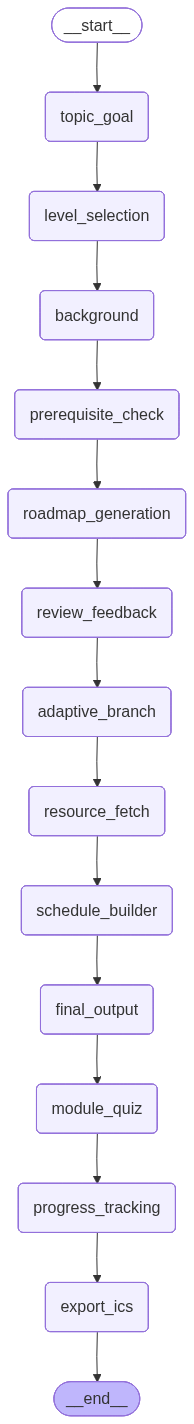

In [42]:
# 6. Build and Visualize the LangGraph Workflow
sg = StateGraph(dict)
for name, func in nodes.items():
    sg.add_node(name, func)
for src, dst in edges:
    sg.add_edge(src, dst)
sg.set_entry_point('topic_goal')

# Compile the StateGraph to a runnable graph object
graph = sg.compile()

# Try to render a mermaid PNG using LangGraph's graph renderer if available, otherwise fallback to networkx plot
from IPython.display import Image, display
try:
    g = graph.get_graph()
    try:
        png_bytes = g.draw_mermaid_png()
        display(Image(png_bytes))
    except Exception as e:
        print('Mermaid PNG render not available or failed:', e)
        # fallback to networkx drawing
        import networkx as _nx
        import matplotlib.pyplot as _plt
        nxg = _nx.DiGraph()
        for s,d in edges:
            nxg.add_edge(s,d)
        _plt.figure(figsize=(12,6))
        pos = _nx.spring_layout(nxg, seed=42)
        _nx.draw(nxg, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, arrows=True)
        _plt.title('LangGraph Workflow Structure (fallback)')
        _plt.show()
except Exception as e:
    print('Graph object not renderable:', e)
    # final fallback: networkx as above
    import networkx as _nx
    import matplotlib.pyplot as _plt
    nxg = _nx.DiGraph()
    for s,d in edges:
        nxg.add_edge(s,d)
    _plt.figure(figsize=(12,6))
    pos = _nx.spring_layout(nxg, seed=42)
    _nx.draw(nxg, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=10, arrows=True)
    _plt.title('LangGraph Workflow Structure (fallback)')
    _plt.show()


In [ ]:
# 7. Run the LangGraph Workflow
graph = sg.compile()
state = globals().get('EXAMPLE_STATE', {})
output = graph.invoke(state)
print("\n--- Workflow Complete ---\n")
print(output)

In [39]:
# 8. Interactive Notebook UI (single cell)
# Lightweight UI using ipywidgets — fetches LLM-updated choices and runs the workflow in a background thread.
import threading, sys
from IPython.display import display, FileLink, HTML
import ipywidgets as widgets

# Widgets
topic_w = widgets.Text(value='Python for DSA', description='Topic:', layout=widgets.Layout(width='70%'))
goal_w = widgets.Text(value='Build a DSA project', description='Goal:', layout=widgets.Layout(width='70%'))
level_w = widgets.Dropdown(options=['None','A1','A2','B1','B2','C1','C2'], description='Level:')
style_w = widgets.Dropdown(options=['Videos','Reading','Projects','Interactive','Mixed'], description='Style:')
time_w = widgets.Text(value='5 hours', description='Hours/week:')
weeks_w = widgets.IntText(value=8, description='Weeks:')
export_w = widgets.Checkbox(value=True, description='Export .ics')
fetch_levels_btn = widgets.Button(description='Fetch Level Descriptions (LLM)', button_style='info')
run_btn = widgets.Button(description='Run Workflow', button_style='primary')
quick_btn = widgets.Button(description='Quick Roadmap → Schedule → Export', button_style='warning')
test_btn = widgets.Button(description='Test OpenRouter', button_style='')

out = widgets.Output(layout={'border': '1px solid black', 'height': '300px', 'overflow': 'auto'})

# Helper writer to stream prints into the output widget
class OutWriter:
    def __init__(self, out_widget):
        self.out = out_widget
    def write(self, s):
        try:
            self.out.append_stdout(s)
        except Exception:
            pass
    def flush(self):
        pass

# Fetch level descriptions via existing helper and update level_w options
def fetch_levels_clicked(b):
    fetch_levels_btn.disabled = True
    with out:
        out.clear_output()
        print('Fetching level descriptions from LLM...')

    def _work():
        try:
            # capture prints from LLM/node into the output widget
            old_stdout = sys.stdout
            sys.stdout = OutWriter(out)
            try:
                state = {'topic': topic_w.value}
                descs = get_topic_level_descriptions_cached(state)
                opts = [(f"{k} - {v}", k) for k, v in descs.items()]
                level_w.options = opts
                with out:
                    print('Level descriptions updated.')
            finally:
                sys.stdout = old_stdout
        except Exception as e:
            with out:
                print('Failed to fetch level descriptions:', e)
        finally:
            fetch_levels_btn.disabled = False

    threading.Thread(target=_work, daemon=True).start()

fetch_levels_btn.on_click(fetch_levels_clicked)

# Run full workflow (keeps existing behaviour)
def run_clicked(b):
    run_btn.disabled = True
    fetch_levels_btn.disabled = True
    test_btn.disabled = True
    quick_btn.disabled = True
    with out:
        out.clear_output()
        print('Starting full workflow (may prompt for inputs in-node if present)...')

    def _run():
        state = {}
        state['topic'] = topic_w.value
        state['goal'] = goal_w.value
        state['estimated_level'] = level_w.value
        state['learning_style'] = style_w.value
        state['available_time'] = time_w.value
        state['target_duration_weeks'] = int(weeks_w.value) if weeks_w.value else None
        state['export_schedule'] = bool(export_w.value)
        try:
            graph = globals().get('graph')
            if graph is None:
                graph = sg.compile()
                globals()['graph'] = graph
        except Exception as e:
            with out:
                print('Failed to compile graph:', e)
            run_btn.disabled = False
            fetch_levels_btn.disabled = False
            test_btn.disabled = False
            quick_btn.disabled = False
            return

        old_stdout = sys.stdout
        sys.stdout = OutWriter(out)
        try:
            result = graph.invoke(state)
            with out:
                print('\n--- Workflow finished ---')
                print('Final state keys:', list(result.keys()))
                if result.get('ics_file'):
                    print('ICS file created:', result['ics_file'])
                    try:
                        display(FileLink(result['ics_file']))
                    except Exception:
                        print('File saved at', result['ics_file'])
                else:
                    print('No .ics file produced.')
        except Exception as e:
            with out:
                print('\nWorkflow failed:', e)
        finally:
            sys.stdout = old_stdout
            run_btn.disabled = False
            fetch_levels_btn.disabled = False
            test_btn.disabled = False
            quick_btn.disabled = False

    threading.Thread(target=_run, daemon=True).start()

run_btn.on_click(run_clicked)

# Quick flow: generate roadmap -> let user provide feedback in UI textarea -> regenerate optional -> build schedule -> export
feedback_area = widgets.Textarea(value='', placeholder='Optional: enter brief feedback to refine roadmap', description='Feedback:', layout=widgets.Layout(width='70%', height='120px'))
apply_feedback_btn = widgets.Button(description='Regenerate Roadmap with Feedback', button_style='')
continue_btn = widgets.Button(description='Continue to Schedule & Export', button_style='success')

# container to hold last generated state
_quick_state = {}

def quick_clicked(b):
    quick_btn.disabled = True
    run_btn.disabled = True
    fetch_levels_btn.disabled = True
    test_btn.disabled = True
    with out:
        out.clear_output()
        print('Quick flow: Generating roadmap...')

    def _work():
        try:
            state = {}
            state['topic'] = topic_w.value
            state['goal'] = goal_w.value
            state['estimated_level'] = level_w.value
            state['learning_style'] = style_w.value
            state['available_time'] = time_w.value
            state['target_duration_weeks'] = int(weeks_w.value) if weeks_w.value else None
            state['export_schedule'] = bool(export_w.value)
            # Generate roadmap (calls LLM)
            # Capture prints from node/LLM into the output widget
            old_stdout = sys.stdout
            sys.stdout = OutWriter(out)
            try:
                roadmap_state = node_generate_roadmap(state)
            finally:
                sys.stdout = old_stdout
            # Save into quick_state
            _quick_state.clear()
            _quick_state.update(roadmap_state)
            with out:
                print('\n--- ROADMAP (preview) ---\n')
                print(roadmap_state.get('roadmap','(no roadmap returned)'))
                print('\nYou can edit feedback in the Feedback box and click "Regenerate Roadmap with Feedback" or click "Continue to Schedule & Export".')
        except Exception as e:
            with out:
                print('Quick flow failed during roadmap generation:', e)
        finally:
            quick_btn.disabled = False
            run_btn.disabled = False
            fetch_levels_btn.disabled = False
            test_btn.disabled = False

    threading.Thread(target=_work, daemon=True).start()

quick_btn.on_click(quick_clicked)

def apply_feedback_clicked(b):
    apply_feedback_btn.disabled = True
    with out:
        print('\nRegenerating roadmap with feedback...')
    def _work():
        try:
            if not _quick_state:
                with out:
                    print('No generated roadmap in quick session. Click Quick Roadmap first.')
                return
            _quick_state['feedback'] = feedback_area.value
            # Capture prints from node/LLM into the output widget
            old_stdout = sys.stdout
            sys.stdout = OutWriter(out)
            try:
                updated = node_generate_roadmap(_quick_state)
            finally:
                sys.stdout = old_stdout
            _quick_state.update(updated)
            with out:
                print('\n--- UPDATED ROADMAP ---\n')
                print(updated.get('roadmap','(no roadmap returned)'))
        except Exception as e:
            with out:
                print('Failed to regenerate roadmap with feedback:', e)
        finally:
            apply_feedback_btn.disabled = False

    threading.Thread(target=_work, daemon=True).start()

apply_feedback_btn.on_click(apply_feedback_clicked)

def continue_clicked(b):
    continue_btn.disabled = True
    with out:
        print('\nBuilding schedule and exporting (if enabled)...')
    def _work():
        try:
            if not _quick_state:
                with out:
                    print('No generated roadmap in quick session. Click Quick Roadmap first.')
                return
            # Build schedule
            # Capture prints from schedule builder and export steps
            old_stdout = sys.stdout
            sys.stdout = OutWriter(out)
            try:
                schedule_state = node_schedule_builder(_quick_state)
                _quick_state.update(schedule_state)
                with out:
                    print('\n--- SCHEDULE PREVIEW ---\n')
                    print(_quick_state.get('schedule','(no schedule returned)'))
                # Export if requested
                if _quick_state.get('export_schedule', False):
                    exported = node_export_schedule_ics(_quick_state)
                    _quick_state.update(exported)
                    with out:
                        if exported.get('ics_file'):
                            print('ICS exported to', exported['ics_file'])
                            try:
                                display(FileLink(exported['ics_file']))
                            except Exception:
                                print('File saved at', exported['ics_file'])
                        else:
                            print('Export step completed but no .ics file produced.')
                else:
                    with out:
                        print('Export skipped (export checkbox not selected).')
            finally:
                sys.stdout = old_stdout
        except Exception as e:
            with out:
                print('Quick continue failed:', e)
        finally:
            continue_btn.disabled = False

    threading.Thread(target=_work, daemon=True).start()

continue_btn.on_click(continue_clicked)

# Quick flow UI elements grouping
quick_box = widgets.VBox([widgets.HTML('<b>Quick Flow</b>'), feedback_area, widgets.HBox([apply_feedback_btn, continue_btn])])

# Layout
left = widgets.VBox([topic_w, goal_w, widgets.HBox([level_w, fetch_levels_btn]), style_w, time_w, weeks_w, export_w, widgets.HBox([quick_btn]) , quick_box])
right = widgets.VBox([widgets.HBox([run_btn, test_btn]), out])
ui = widgets.HBox([left, right], layout=widgets.Layout(align_items='flex-start'))

display(HTML('<h3>Interactive LangGraph Runner</h3>'))
display(ui)

print('UI ready. Use "Fetch Level Descriptions" to refresh level choices from the LLM, then click "Quick Roadmap" or "Run Workflow".')
